importing the libraries

In [1]:
!pip install torch

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup


C:\Users\richu\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Load and preprocess the data
data = pd.read_csv('datset trial - malayalam_train (1) - datset - malayalam_train (1).csv.csv')
data.head(700)

,text,category
0,7.3k dislike adichavanmaarod onne parayanollu....,Negative
1,Feeling sad am studying in punjab ivde release...,Negative
2,1k dislikes Ella dislike pannikalkum endhe nad...,Negative
3,Adhikam hype venda,Negative
4,Natural venam polum side lottu maarinikke anga...,Negative
...,...,...
695,Mammookka fans like adi. Love u ikka,Positive
696,Oh mass o mass laletta katta waiting....Bgm,Positive
697,Ith powlichu vaariyitte pooku....,Positive
698,June 16 Keralakara ilakki marikkum ikka,Positive


In [3]:
label_map = {'Positive': 1, 'Negative': 0}  # Define your label mapping as needed
data['category'] = data['category'].map(label_map)
data.head()

,text,category
0,7.3k dislike adichavanmaarod onne parayanollu....,0
1,Feeling sad am studying in punjab ivde release...,0
2,1k dislikes Ella dislike pannikalkum endhe nad...,0
3,Adhikam hype venda,0
4,Natural venam polum side lottu maarinikke anga...,0


tokenize

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')


In [5]:
max_length = 128 # You can adjust this as needed
input_ids = []
attention_masks = []

for text in data['text']:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=max_length,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt'
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(data['category'].values)  # Convert to tensor

# Split the dataset into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.1)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\richu\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [6]:
# Create DataLoader for training and validation
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [7]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Fine-tune BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 10

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

C:\Users\richu\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Average Loss: 0.6413, Training Accuracy: 0.6099, Validation Loss: 0.5298, Validation Accuracy: 0.7107
Epoch 2/10, Average Loss: 0.4983, Training Accuracy: 0.7534, Validation Loss: 0.5005, Validation Accuracy: 0.7603
Epoch 3/10, Average Loss: 0.3839, Training Accuracy: 0.8473, Validation Loss: 0.4698, Validation Accuracy: 0.7851
Epoch 4/10, Average Loss: 0.2939, Training Accuracy: 0.8832, Validation Loss: 0.4935, Validation Accuracy: 0.7851
Epoch 5/10, Average Loss: 0.2455, Training Accuracy: 0.9052, Validation Loss: 0.4478, Validation Accuracy: 0.8017
Epoch 6/10, Average Loss: 0.1852, Training Accuracy: 0.9347, Validation Loss: 0.4623, Validation Accuracy: 0.8264
Epoch 7/10, Average Loss: 0.1710, Training Accuracy: 0.9494, Validation Loss: 0.5154, Validation Accuracy: 0.8264
Epoch 8/10, Average Loss: 0.1216, Training Accuracy: 0.9669, Validation Loss: 0.5252, Validation Accuracy: 0.8182
Epoch 9/10, Average Loss: 0.1098, Training Accuracy: 0.9706, Validation Loss: 0.5761, Va

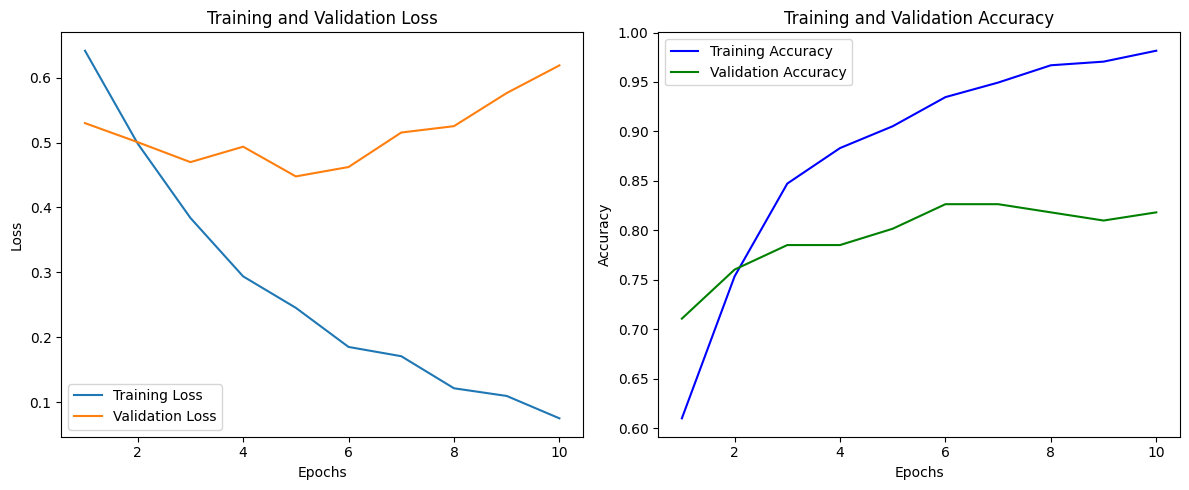

In [9]:
import matplotlib.pyplot as plt

# Lists to store training and validation statistics
train_loss_values = []
validation_loss_values = []
train_accuracy_values = []
validation_accuracy_values = []

# Training loop
accumulation_steps = 4
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss = loss / accumulation_steps  # Scale loss to account for accumulation
        loss.backward()
        if (step + 1) % accumulation_steps == 0 or step == len(train_dataloader) - 1:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
        # Calculate training accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predictions == inputs['labels'])
        total_predictions += len(predictions)
        
    average_loss = total_loss / len(train_dataloader)
    train_loss_values.append(average_loss)  # Store training loss for the epoch
    train_accuracy = correct_predictions / total_predictions
    train_accuracy_values.append(train_accuracy)  # Store training accuracy for the epoch
    
    # Validation phase
    model.eval()
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
            outputs = model(**inputs)
            loss = outputs.loss
            validation_loss += loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(predictions == inputs['labels'])
            total_predictions += len(predictions)
    validation_loss /= len(validation_dataloader)
    validation_accuracy = correct_predictions / total_predictions
    validation_loss_values.append(validation_loss)  # Store validation loss for the epoch
    validation_accuracy_values.append(validation_accuracy)  # Store validation accuracy for the epoch
    
    print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

# Plotting the graphs
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_values, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracy_values, label='Training Accuracy', color='blue')
plt.plot(range(1, epochs + 1), validation_accuracy_values, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import accuracy_score, classification_report

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# Initialize variables to calculate validation loss and accuracy
validation_loss = 0
num_batches = 0
correct_predictions = 0
total_predictions = 0

# Iterate over validation dataset
for batch in validation_dataloader:
    # Move batch to appropriate device
    batch = tuple(t.to(device) for t in batch)
    inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
    
    # Disable gradient calculation
    with torch.no_grad():
        outputs = model(**inputs)
        loss = outputs.loss.item()  # Extract loss value from outputs
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        predictions.extend(logits.argmax(axis=-1))
        true_labels.extend(inputs['labels'].detach().cpu().numpy())
        validation_loss += loss
        num_batches += 1

        # Calculate validation accuracy
        predicted_labels = logits.argmax(axis=-1)
        correct_predictions += (predicted_labels == inputs['labels'].cpu().numpy()).sum()
        total_predictions += len(predicted_labels)

# Calculate average validation loss
validation_loss /= num_batches

# Print validation loss
print("Validation Loss:", validation_loss)

# Calculate validation accuracy
validation_accuracy = correct_predictions / total_predictions
print("Validation Accuracy:", validation_accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predictions))



Validation Loss: 0.6187054826878011
Validation Accuracy: 0.8181818181818182
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85        75
           1       0.72      0.85      0.78        46

    accuracy                           0.82       121
   macro avg       0.81      0.82      0.81       121
weighted avg       0.83      0.82      0.82       121



In [11]:
# Calculate accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
accuracy = accuracy_score(true_labels, predictions)
print("Validation Accuracy:", accuracy)
print(classification_report(true_labels, predictions))

Validation Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       0.90      0.80      0.85        75
           1       0.72      0.85      0.78        46

    accuracy                           0.82       121
   macro avg       0.81      0.82      0.81       121
weighted avg       0.83      0.82      0.82       121



In [12]:
import joblib
joblib.dump(model,'trained_model')


['trained_model']

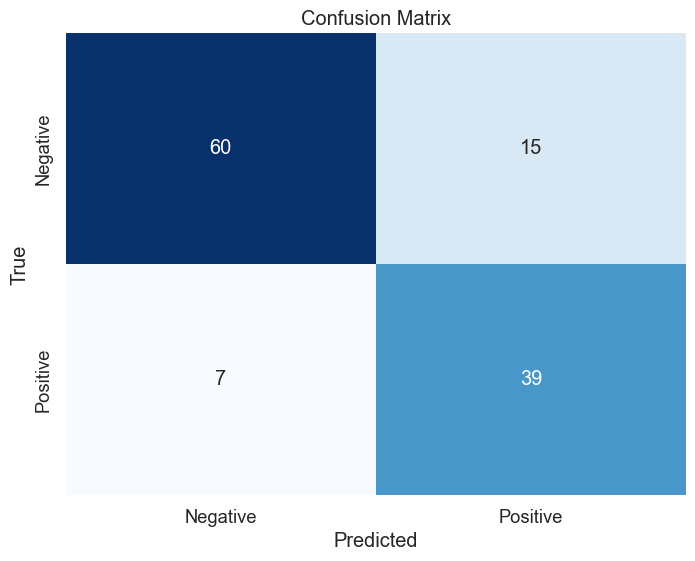

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [14]:
data.shape

(1208, 2)